# Titanic dataset (Kaggle)

This is an example of applying pipelines on multiple models with different parameters grids.
I used a list with estimators and parameter grids to perform grid search (GridSearchCV) on three models (SGDClassifier, Logistic Regression, and Random Forest). And also a Voting classifier.

Score: 0.78708

## Load packages and data

Meaning of some of the variables:
- **Pclass**: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- **sibsp**: Number of Siblings/Spouses Aboard
- **parch**: Number of Parents/Children Aboard
- **ticket**: Ticket Number
- **fare**: Passenger Fare
- **cabin**: Cabin
- **embarked**: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [376]:
# Load packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# Load the dataset
def load_ds(path, filename):
    # path: path to the file
    # filename: name of the file to load
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

# Load dataset
train = load_ds(path='data', filename='train.csv')
test = load_ds(path='data', filename='test.csv')

## Split train and test set

This splits the train data set into X_y_train and X_y_test using indices stratified using the features Sex and Pclass.
X_y_train_tmp is used to explore the data set.

In [377]:
# Create cross-validation object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=93)

# Create train and test sets via "Stratified" indices
for train_index, test_index in split.split(train, train[['Sex', 'Pclass']]):
    X_y_train = train.loc[train_index]
    X_y_test = train.loc[test_index]

X_y_train_tmp = X_y_train.copy()
print(f"Shape X_y_train: {X_y_train.shape}")
print(f"Shape X_y_train_tmp: {X_y_train_tmp.shape}")
print(f"Shape X_y_test: {X_y_test.shape}")

Shape X_y_train: (712, 12)
Shape X_y_train_tmp: (712, 12)
Shape X_y_test: (179, 12)


## Explore data set

In [378]:
print(f'List of features: {list(X_y_train_tmp)}\n')
print(X_y_train_tmp.head())

List of features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

     PassengerId  Survived  Pclass  \
568          569         0       3   
864          865         0       2   
773          774         0       3   
314          315         0       2   
416          417         1       2   

                                                Name     Sex   Age  SibSp  \
568                              Doharr, Mr. Tannous    male   NaN      0   
864                           Gill, Mr. John William    male  24.0      0   
773                                  Elias, Mr. Dibo    male   NaN      0   
314                               Hart, Mr. Benjamin    male  43.0      1   
416  Drew, Mrs. James Vivian (Lulu Thorne Christian)  female  34.0      1   

     Parch        Ticket     Fare Cabin Embarked  
568      0          2686   7.2292   NaN        C  
864      0        233866  13.0000   NaN        S  
773      0         

The comumns Age Cabin, and Embarked have missing values

In [379]:
print(X_y_train_tmp.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 568 to 413
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          564 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        165 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB
None


In [380]:
print(X_y_train_tmp.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   712.000000  712.000000  712.000000  564.000000  712.000000   
mean    449.351124    0.393258    2.307584   29.712624    0.490169   
std     256.932856    0.488817    0.836609   14.175280    1.041968   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     228.750000    0.000000    2.000000   21.000000    0.000000   
50%     447.500000    0.000000    3.000000   28.000000    0.000000   
75%     670.250000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  712.000000  712.000000  
mean     0.360955   32.267708  
std      0.793995   51.275418  
min      0.000000    0.000000  
25%      0.000000    7.895800  
50%      0.000000   14.454200  
75%      0.000000   30.548950  
max      6.000000  512.329200  


## Categorical variables

In [381]:
print("Sex - value counts"+ "-" *50)
print(X_y_train_tmp["Sex"].value_counts(dropna=False))

print("\nEmbarked - value counts"+ "-" *50)
print(X_y_train_tmp["Embarked"].value_counts(dropna=False))

Sex - value counts--------------------------------------------------
male      461
female    251
Name: Sex, dtype: int64

Embarked - value counts--------------------------------------------------
S      510
C      137
Q       63
NaN      2
Name: Embarked, dtype: int64


## Plots

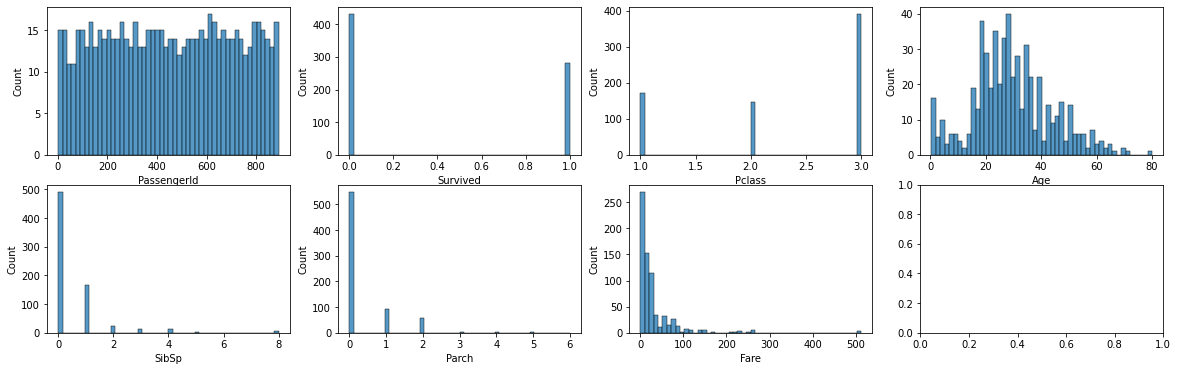

In [382]:
hs = X_y_train_tmp[["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]

f, axes = plt.subplots(2, 4, figsize=(20, 6))
for ax, feature in zip(axes.flat, hs.columns):
    sns.histplot(hs[feature], bins=50, ax=ax)

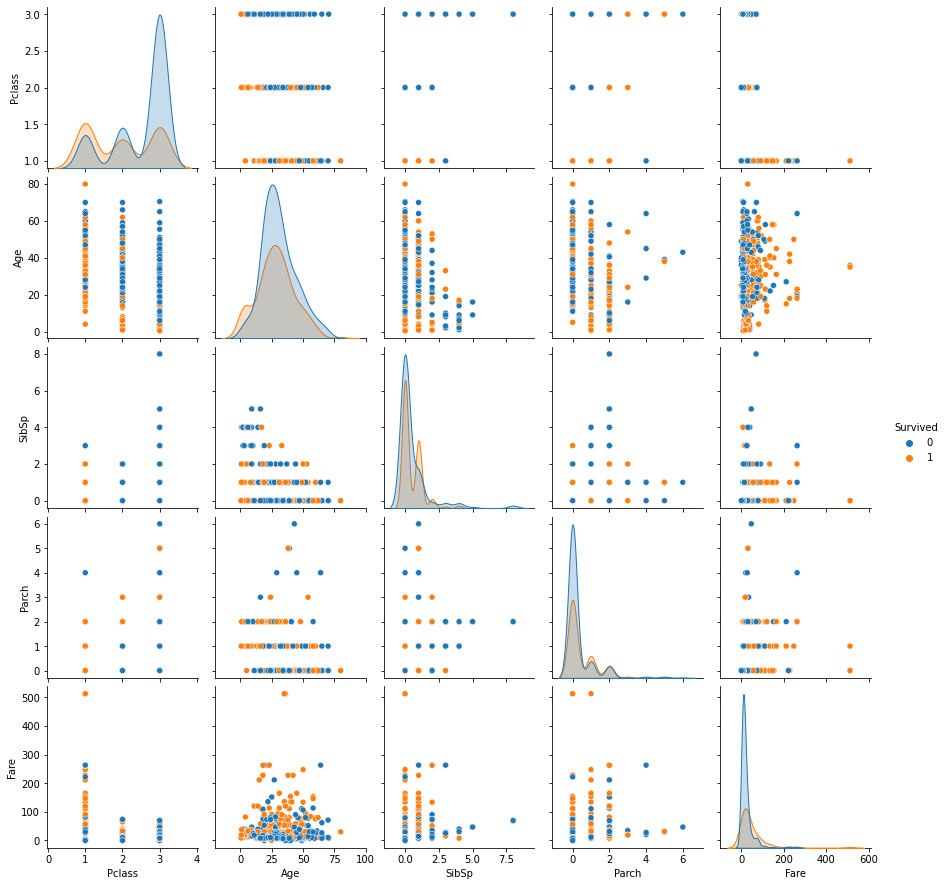

In [383]:
sns.pairplot(X_y_train_tmp[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]], hue="Survived")

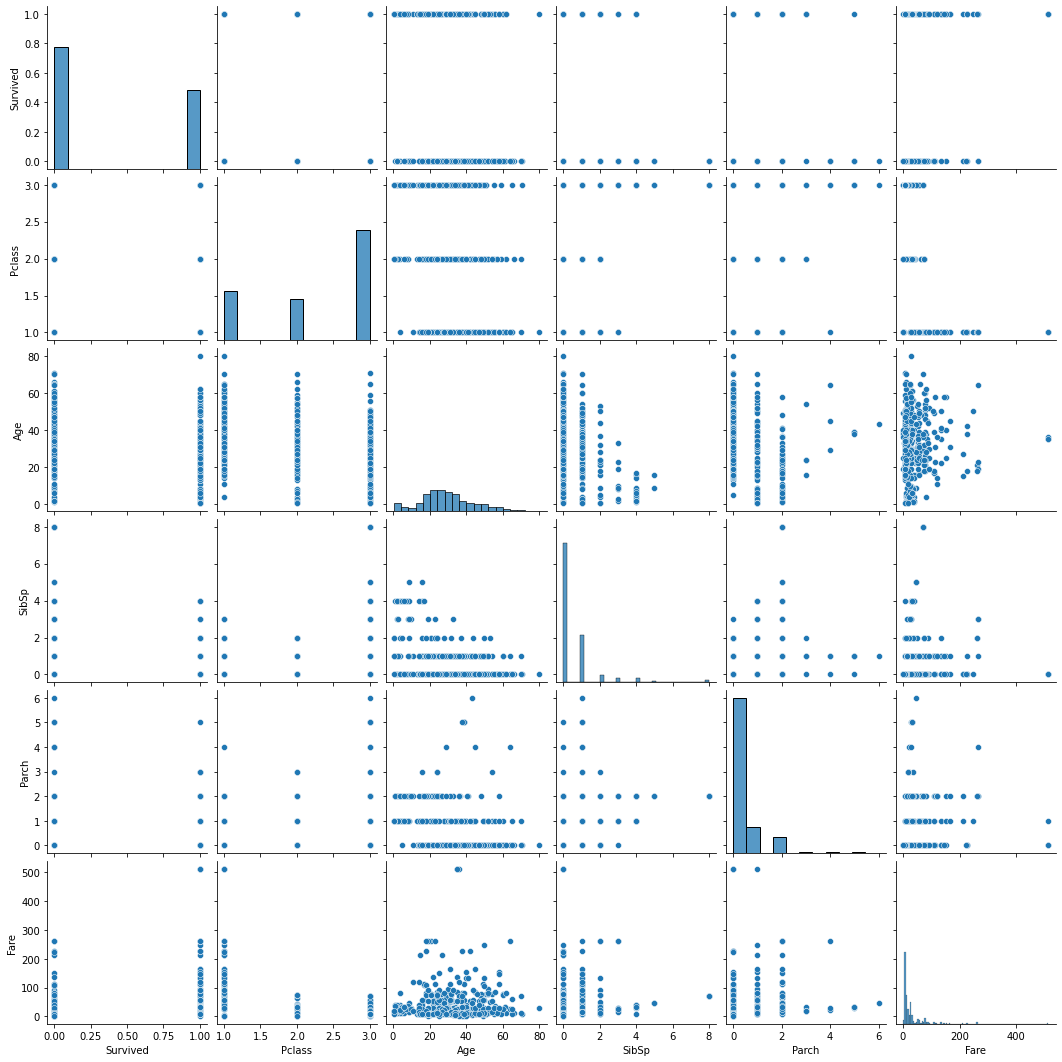

In [384]:
sns.pairplot(X_y_train_tmp[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]])

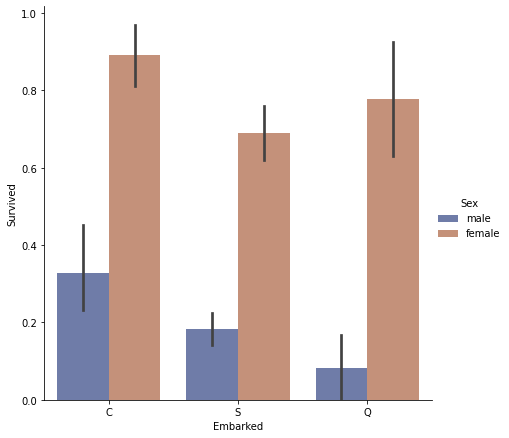

In [385]:
sns.catplot(
    data=X_y_train_tmp, kind="bar",
    x="Embarked", y="Survived", hue="Sex",
    palette="dark", alpha=.6, height=6
)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

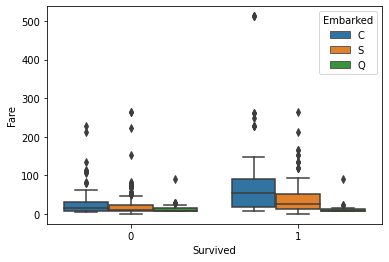

In [386]:
sns.boxplot(data=X_y_train_tmp, x="Survived", y="Fare", hue="Embarked")

### SibSp

Create a categorical version of SibSP

In [387]:
get_percent = lambda x : x.value_counts() / len(x)
get_percent.__name__ = "percent"
(X_y_train_tmp
    .SibSp
    .agg(['value_counts', get_percent])
    .sort_index())

,value_counts,percent
0,492,0.691011
1,165,0.231742
2,23,0.032303
3,12,0.016854
4,13,0.018258
5,2,0.002809
8,5,0.007022


In [388]:
X_y_train_tmp['SibSp_cat'] = pd.cut(X_y_train_tmp['SibSp'], bins=[-0.5,0.5,1.5,np.inf], labels=['0', '1', '2more'])
X_y_train_tmp['SibSp_cat'].agg(['value_counts', get_percent]).sort_index()

,value_counts,percent
0,492,0.691011
1,165,0.231742
2more,55,0.077247


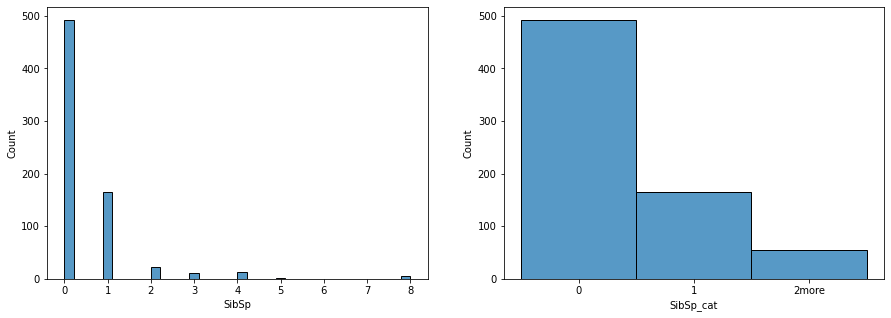

In [389]:
hs = X_y_train_tmp[['SibSp', 'SibSp_cat']]
f, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, feature in zip(axes, hs.columns):
    sns.histplot(hs[feature], ax=ax)

### Parch

Create a categorical version of Parch

In [390]:
(X_y_train_tmp
    .Parch
    .agg(['value_counts', get_percent])
    .sort_index())

,value_counts,percent
0,550,0.772472
1,93,0.130618
2,57,0.080056
3,4,0.005618
4,3,0.004213
5,4,0.005618
6,1,0.001404


In [391]:
X_y_train_tmp['Parch_cat'] = pd.cut(X_y_train_tmp['Parch'], bins=[-0.5,0.5,1.5,np.inf], labels=['0', '1', '2more'])
X_y_train_tmp['Parch_cat'].agg(['value_counts', get_percent]).sort_index()

,value_counts,percent
0,550,0.772472
1,93,0.130618
2more,69,0.096910


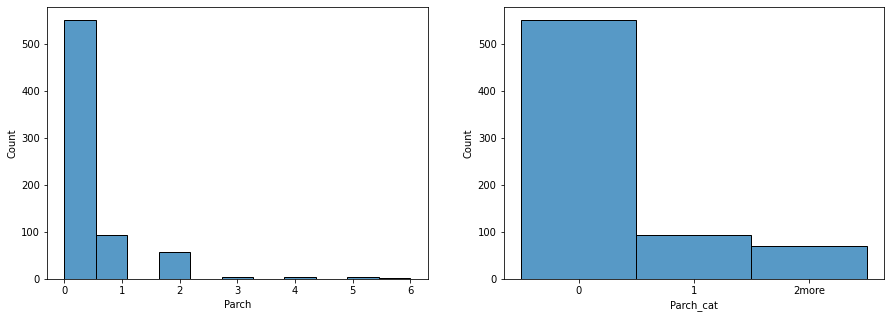

In [392]:
hs = X_y_train_tmp[['Parch', 'Parch_cat']]

f, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, feature in zip(axes, hs.columns):
    sns.histplot(hs[feature], ax=ax)

### Fare

For the feature Fare, create a categorical version, a log transform and a sqrt transform

In [393]:
print(X_y_train_tmp['Fare'].describe())
print(f"\nquantile = \n{X_y_train_tmp['Fare'].quantile([.1, .2,.3,.4,.5,.6,.7,.8,.9,]).round(2)}")

count    712.000000
mean      32.267708
std       51.275418
min        0.000000
25%        7.895800
50%       14.454200
75%       30.548950
max      512.329200
Name: Fare, dtype: float64

quantile = 
0.1     7.50
0.2     7.85
0.3     8.05
0.4    10.50
0.5    14.45
0.6    21.00
0.7    26.55
0.8    39.69
0.9    77.89
Name: Fare, dtype: float64


In [394]:
X_y_train_tmp['Fare_sqrt'] = np.sqrt(X_y_train_tmp['Fare'])
X_y_train_tmp['Fare_log'] = np.log(X_y_train_tmp['Fare']+1)
X_y_train_tmp['Fare_cat'] = pd.cut(X_y_train_tmp['Fare'], bins=[-0.5, 8, 16, 31, np.inf], labels=['1', '2', '3', '4'])
X_y_train_tmp['Fare_cat'].agg(['value_counts', get_percent]).sort_index()

,value_counts,percent
1,196,0.275281
2,197,0.276685
3,146,0.205056
4,173,0.242978


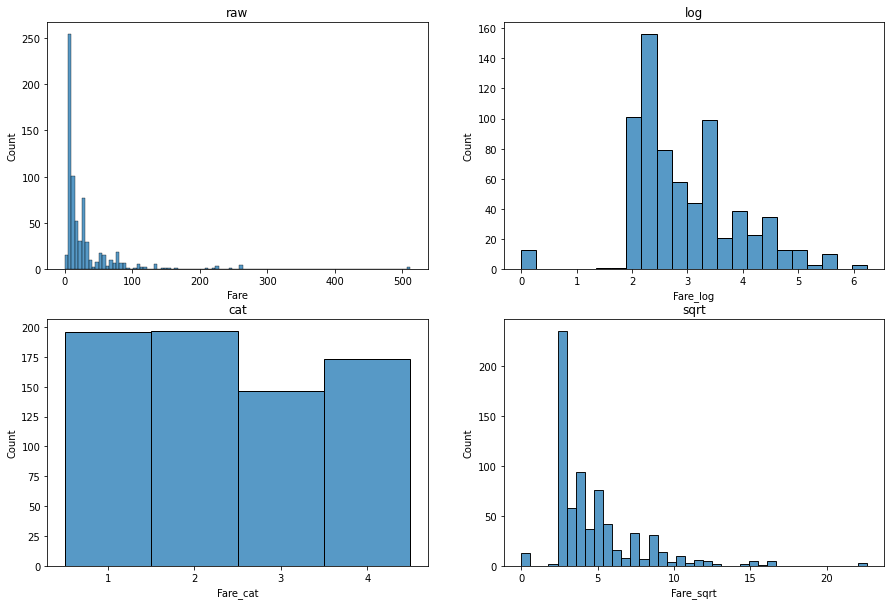

In [395]:
hs = X_y_train_tmp[['Fare', 'Fare_log', 'Fare_cat', 'Fare_sqrt']]
titles = ['raw', 'log', 'cat', 'sqrt']

f, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, feature, ttl in zip(axes.flat, hs.columns, titles):
    sns.histplot(hs[feature], ax=ax).set(title=ttl)

## Prepare data for the models

In [396]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Survived", "PassengerId", "Name", "Ticket", "Cabin"], axis=1)
X_test = X_y_test.drop(["Survived", "PassengerId", "Name", "Ticket", "Cabin"], axis=1)

y_train = X_y_train["Survived"].copy()
y_test =  X_y_test["Survived"].copy()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(712, 7) (712,) (179, 7) (179,)


In [397]:
print('X_train', '-'*60)
print(X_train.head())
print('\ny_train', '-'*60)
print(y_train.head())
print('\nX_test', '-'*60)
print(X_test.head())
print('\ny_test', '-'*60)
print(y_test.head())

X_train ------------------------------------------------------------
     Pclass     Sex   Age  SibSp  Parch     Fare Embarked
568       3    male   NaN      0      0   7.2292        C
864       2    male  24.0      0      0  13.0000        S
773       3    male   NaN      0      0   7.2250        C
314       2    male  43.0      1      1  26.2500        S
416       2  female  34.0      1      1  32.5000        S

y_train ------------------------------------------------------------
568    0
864    0
773    0
314    0
416    1
Name: Survived, dtype: int64

X_test ------------------------------------------------------------
     Pclass     Sex   Age  SibSp  Parch      Fare Embarked
823       3  female  27.0      0      1   12.4750        S
118       1    male  24.0      0      1  247.5208        C
642       3  female   2.0      3      2   27.9000        S
341       1  female  24.0      3      2  263.0000        S
272       2  female  41.0      0      1   19.5000        S

y_test --------

## Define pipelines

Create pipelines to transform and preprocess the features.

**CombinedAttributesAdder** is a class that transforms the features "SibSp" (numerical), "Parch" (numerical), "Fare" (numerical) into "SibSp_cat" (categorical), "Parch_cat" (categorical), "Fare_cat" (categorical), "Fare_log" (log transform), and "Fare_sqrt" (sqrt transform).

**num_pipeline** preprocesses the numerical attributes (it uses SimpleImputer() and StandardScaler()).

**cat_pipeline** preprocesses the categorical attributed (it uses SimpleImputer() and OneHotEncoder()).

**cols_transformer_no** applies **num_pipeline** to "Pclass", "Age", "SibSp", "Parch", and "Fare" and **cat_pipeline** to "Sex" and "Embarked"; that is it uses the origial features with no transformation).

**full_pipeline_no** combines **CombinedAttributesAdder** and **cols_transformer_no**.

**cols_transformer_cat** applies **num_pipeline** to "Pclass" and "Age", and **cat_pipeline** to "Sex", "Embarked", "SibSp_cat","Parch_cat", and "Fare_cat".

**full_pipeline_cat** combines **CombinedAttributesAdder** and **cols_transformer_cat**.

**cols_transformer_log** applies **num_pipeline** to "Pclass", "Age" and "Fare_log", and **cat_pipeline** to "Sex", "Embarked", "SibSp_cat", and "Parch_cat".

**full_pipeline_log** combines **CombinedAttributesAdder** and **cols_transformer_log**.

**cols_transformer_sqrt** applies **num_pipeline** to "Pclass", "Age" and "Fare_sqrt", and **cat_pipeline** to "Sex", "Embarked", "SibSp_cat", and "Parch_cat".

**full_pipeline_sqrt** combines **CombinedAttributesAdder** and **cols_transformer_sqrt**.


In [398]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    def fit(self, X, y=None):  # needed later for the pipeline
        return self  # nothing else to do

    def transform(self, X):
        X['SibSp_cat'] = pd.cut(
            X['SibSp'],
            bins=[-0.5,0.5,1.5,np.inf],
            labels=['0', '1', '2more'])
        X['Parch_cat'] = pd.cut(
            X['Parch'],
            bins=[-0.5,0.5,1.5,np.inf],
            labels=['0', '1', '2more'])
        X['Fare_cat'] = pd.cut(
            X['Fare'],
            bins=[-0.5, 8, 16, 31, np.inf],
            labels=['1', '2', '3', '4'])
        X['Fare_log'] = np.log(train['Fare']+1)
        X['Fare_sqrt'] = np.sqrt(train['Fare'])
        return X


# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with median
    ('imputer', SimpleImputer()),
    # standardize the variables
    ('std_scaler', StandardScaler())])

# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder())])

# Define numerical and categorical attributes
# All attribs: "Sex", "Embarked", "Pclass", "Age", "SibSp", "Parch", "Fare"
# Attribute list for no transformation
cat_attribs_no = ["Sex", "Embarked"]
num_attribs_no = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
# Attribute list for categorical transformation
cat_attribs_cat = ["Sex", "Embarked", "SibSp_cat","Parch_cat","Fare_cat"]
num_attribs_cat = ["Pclass", "Age"]
# Attribute list for log transformation
cat_attribs_log = ["Sex", "Embarked", "SibSp_cat","Parch_cat"]
num_attribs_log = ["Pclass", "Age", "Fare_log"]
# Attribute list for sqrt transformation
cat_attribs_sqrt = ["Sex", "Embarked", "SibSp_cat","Parch_cat"]
num_attribs_sqrt = ["Pclass", "Age", "Fare_sqrt"]

# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer_no = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, num_attribs_no),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, cat_attribs_no)])
full_pipeline_no = Pipeline([
    # add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform num and cat attributes
    ("cols_transformer", cols_transformer_no)])

cols_transformer_cat = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, num_attribs_cat),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, cat_attribs_cat)])
full_pipeline_cat = Pipeline([
    # add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform num and cat attributes
    ("cols_transformer", cols_transformer_cat)])

cols_transformer_log = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, num_attribs_log),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, cat_attribs_log)])
full_pipeline_log = Pipeline([
    # add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform num and cat attributes
    ("cols_transformer", cols_transformer_log)])

cols_transformer_sqrt = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, num_attribs_sqrt),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, cat_attribs_sqrt)])
full_pipeline_sqrt = Pipeline([
    # add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform num and cat attributes
    ("cols_transformer", cols_transformer_sqrt)])

## Classifiers Pipeline

Create a pipeline for different algorithms and param_grid. Each algorithm is applied to all the four data set obtained with the transformetions applied above (i.e., full_pipeline_no, full_pipeline_cat, full_pipeline_log, and full_pipeline_sqrt).

These algorithms are tested:
- SGDClassifier
- Logistic Regression
- Random Forest

In [399]:
print(full_pipeline_no.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'attribs_adder', 'cols_transformer', 'cols_transformer__n_jobs', 'cols_transformer__remainder', 'cols_transformer__sparse_threshold', 'cols_transformer__transformer_weights', 'cols_transformer__transformers', 'cols_transformer__verbose', 'cols_transformer__verbose_feature_names_out', 'cols_transformer__num', 'cols_transformer__cat', 'cols_transformer__num__memory', 'cols_transformer__num__steps', 'cols_transformer__num__verbose', 'cols_transformer__num__imputer', 'cols_transformer__num__std_scaler', 'cols_transformer__num__imputer__add_indicator', 'cols_transformer__num__imputer__copy', 'cols_transformer__num__imputer__fill_value', 'cols_transformer__num__imputer__missing_values', 'cols_transformer__num__imputer__strategy', 'cols_transformer__num__imputer__verbose', 'cols_transformer__num__std_scaler__copy', 'cols_transformer__num__std_scaler__with_mean', 'cols_transformer__num__std_scaler__with_std', 'cols_transformer__cat__memory', 'cols_trans

In [400]:
def get_name(estimator):
    name = estimator.__class__.__name__
    if name == "Pipeline":
        name = [get_name(est[1]) for est in estimator.steps]
        name = " + ".join(name)
    return name


classifiers = [
    # SGDClassifier with "full_pipeline_no"
    (
        Pipeline([
            ("preparation", full_pipeline_no),
            ("sgd_clf", SGDClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'sgd_clf__penalty': ['l2', 'l1'],
         'sgd_clf__alpha': [0.0001, 0.001, 0.01]},
    ),
    # SGDClassifier with "full_pipeline_cat"
    (
        Pipeline([
            ("preparation", full_pipeline_cat),
            ("sgd_clf", SGDClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'sgd_clf__penalty': ['l2', 'l1'],
         'sgd_clf__alpha': [0.0001, 0.001, 0.01]}
    ),
    # SGDClassifier with "full_pipeline_log"
    (
        Pipeline([
            ("preparation", full_pipeline_log),
            ("sgd_clf", SGDClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'sgd_clf__penalty': ['l2', 'l1'],
         'sgd_clf__alpha': [0.0001, 0.001, 0.01]}
    ),
    # SGDClassifier with "full_pipeline_sqrt"
    (
        Pipeline([
            ("preparation", full_pipeline_sqrt),
            ("sgd_clf", SGDClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'sgd_clf__penalty': ['l2', 'l1'],
         'sgd_clf__alpha': [0.0001, 0.001, 0.01]}
    ),
    # Logistic Regression with "full_pipeline_no"
    (
        Pipeline([
            ("preparation", full_pipeline_no),
            ("log_reg", LogisticRegression(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'log_reg__solver': ['lbfgs', 'liblinear'],
         # the higher C, the less regularization
         'log_reg__C': [0.1, 1, 10]}
    ),
    # Logistic Regression with "full_pipeline_cat"
    (
        Pipeline([
            ("preparation", full_pipeline_cat),
            ("log_reg", LogisticRegression(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'log_reg__solver': ['lbfgs', 'liblinear'],
         # the higher C, the less regularization
         'log_reg__C': [0.1, 1, 10]}
    ),
    # Logistic Regression with "full_pipeline_log"
    (
        Pipeline([
            ("preparation", full_pipeline_log),
            ("log_reg", LogisticRegression(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'log_reg__solver': ['lbfgs', 'liblinear'],
         # the higher C, the less regularization
         'log_reg__C': [0.1, 1, 10]}
    ),
    # Logistic Regression with "full_pipeline_sqrt"
    (
        Pipeline([
            ("preparation", full_pipeline_sqrt),
            ("log_reg", LogisticRegression(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'log_reg__solver': ['lbfgs', 'liblinear'],
         # the higher C, the less regularization
         'log_reg__C': [0.1, 1, 10]}
    ),
    # Random Forest with "full_pipeline_no"
    (
        Pipeline([
            ("preparation", full_pipeline_no),
            ("rnd_clf", RandomForestClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'rnd_clf__n_estimators': [100, 300, 400, 500, 600],
         'rnd_clf__max_depth': [None, 5, 10]}
    ),

    # Random Forest with "full_pipeline_cat"
    (
        Pipeline([
            ("preparation", full_pipeline_cat),
            ("rnd_clf", RandomForestClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'rnd_clf__n_estimators': [100, 300, 400, 500, 600],
         'rnd_clf__max_depth': [None, 5, 10]}
    ),

    # Random Forest with "full_pipeline_log"
    (
        Pipeline([
            ("preparation", full_pipeline_log),
            ("rnd_clf", RandomForestClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'rnd_clf__n_estimators': [100, 300, 400, 500, 600],
         'rnd_clf__max_depth': [None, 5, 10]}
    ),

    # Random Forest with "full_pipeline_sqrt"
    (
        Pipeline([
            ("preparation", full_pipeline_sqrt),
            ("rnd_clf", RandomForestClassifier(random_state=93))
        ]),
        {'preparation__cols_transformer__num__imputer__strategy': ['mean', 'median'],
         'rnd_clf__n_estimators': [100, 300, 400, 500, 600],
         'rnd_clf__max_depth': [None, 5, 10]}
    ),
    
]

# print(classifiers)
# print(classifiers[1][0].get_params().keys())
# print(classifiers[0][1])

# names for the features transformation
name_transform = ['no', 'cat', 'log', 'sqrt'] * int(len(classifiers) / 4)
names = [get_name(e) for e, _ in classifiers]
names = [i + ' --- ' + j for i, j in zip(name_transform, names)]

Run a grid search and select the best models

In [401]:
best_models = []
for est_idx, (name, (estimator, param_grid)) in enumerate(zip(names, classifiers)):
        clf = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=5, # train across 5 folds
            scoring='accuracy',
            verbose=1
        )
        print("\nFITTING", "-"*70)
        clf.fit(X_train, y_train)
        # score = clf.score(X_train, y_train)
        # print(f"\n{name}: {score:.3f}")
        # print('Best params: ', clf.best_params_)
        # print('Best score: ', clf.best_score_)
        mod = (name, clf.best_estimator_, clf.best_params_, clf.best_score_)
        best_models.append(mod)


FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

FITTING ----

Print parameters and scores of the best models

In [402]:
# i=0
# for name, estimator, params, score_val in best_models:
#         print("-"*80)
#         score = estimator.score(X_train, y_train)
#         print(f"Model {i}: {name}")
#         print(f'parameter: {params}')
#         print(f"Training set score: {score:.3f} ---- Validation score: {score_val:.3f}")
#         i+=1

# print(best_models[0]) # print first best model
i=int(0)
p1 = pd.DataFrame({'model_N' : [],'cols_transformer': [], 'model': [], 'train_score' : [], 'val_score': []})
for name, estimator, params, score_val in best_models:
        n1 = name.split(" --- ")[0]
        n2 = name.split(" + ")[2]
        score = estimator.score(X_train, y_train)
        p1.loc[len(p1)] = [int(i), n1, n2, score.round(3), score_val.round(3)]
        i+=1

print(p1)

    model_N cols_transformer                   model  train_score  val_score
0       0.0               no           SGDClassifier        0.792      0.789
1       1.0              cat           SGDClassifier        0.787      0.791
2       2.0              log           SGDClassifier        0.799      0.794
3       3.0             sqrt           SGDClassifier        0.787      0.791
4       4.0               no      LogisticRegression        0.798      0.794
5       5.0              cat      LogisticRegression        0.810      0.803
6       6.0              log      LogisticRegression        0.805      0.802
7       7.0             sqrt      LogisticRegression        0.806      0.803
8       8.0               no  RandomForestClassifier        0.848      0.819
9       9.0              cat  RandomForestClassifier        0.846      0.812
10     10.0              log  RandomForestClassifier        0.853      0.809
11     11.0             sqrt  RandomForestClassifier        0.853      0.809

In [403]:
print(f"The max val_score is {p1['val_score'].max()} from model {p1['val_score'].idxmax()}")
max_val_score = p1['val_score'].idxmax()
# print(best_models[0]) # print first best model
name, estimator, params, score_val = best_models[max_val_score]
score = estimator.score(X_train, y_train)

print(f"\nModel {max_val_score}: {name}")
print(f'\nparameter: {params}')
print(f"\nTraining set score: {score:.3f} ---- Validation score: {score_val:.3f}")


The max val_score is 0.819 from model 8

Model 8: no --- CombinedAttributesAdder + ColumnTransformer + RandomForestClassifier

parameter: {'preparation__cols_transformer__num__imputer__strategy': 'median', 'rnd_clf__max_depth': 5, 'rnd_clf__n_estimators': 100}

Training set score: 0.848 ---- Validation score: 0.819


## Retrain best model

The following model is equivalent to the model 8 of the "classifiers" pipeline, that is:

Model 8: no --- CombinedAttributesAdder + ColumnTransformer + RandomForestClassifier

with the following hyperparameters:
- 'preparation__cols_transformer__num__imputer__strategy': 'median'
- 'rnd_clf__max_depth': 5
- 'rnd_clf__n_estimators': 100

In [404]:
# Model 8: no --- CombinedAttributesAdder + ColumnTransformer + RandomForestClassifier
# 'preparation__cols_transformer__num__imputer__strategy': 'median'
# 'rnd_clf__max_depth': 5
# 'rnd_clf__n_estimators': 100
rf_clf = Pipeline([
    ("preparation", full_pipeline_no),
    ("rnd_clf", RandomForestClassifier(max_depth=5, n_estimators=100, random_state=93))
])

#print(rf_clf.get_params().keys())
rf_clf.set_params(preparation__cols_transformer__num__imputer__strategy='median')

rf_clf.fit(X_train, y_train)

print(f'Score of the retrained Random Forest Classifier: {rf_clf.score(X_train, y_train)}')
print(f'Score of Model 8 (Random Forest Classifier):     {best_models[8][1].score(X_train, y_train)}')

Score of the retrained Random Forest Classifier: 0.848314606741573
Score of Model 8 (Random Forest Classifier):     0.848314606741573


## Voting classifier

Create a voting classifier using the models above. One model for each algorithm (SGDClassifier, Logistic Regression, and Random Forest).

In [405]:
voting_clf = VotingClassifier(
    estimators=[
        ('no_sgd', best_models[2][1]),
        ('cat_lr', best_models[5][1]),
        ('no_rf', best_models[8][1])],
    voting='hard')

voting_clf.fit(X_train, y_train)
print(f'Training set score: {voting_clf.score(X_train, y_train):.3f}')

Training set score: 0.831


## Test set (subset from train.csv)

In [406]:
print('Voting classifier')
print(f'Test score: {voting_clf.score(X_test, y_test):.3f}') # Test score: 0.804

print('\nRetrained Random Forest Classifier')
print(f'Test score: {rf_clf.score(X_test, y_test):.3f}')

print('\nModel 8 (Random Forest Classifier)')
print(f'Test score: {best_models[8][1].score(X_test, y_test):.3f}')

Voting classifier
Test score: 0.827

Retrained Random Forest Classifier
Test score: 0.844

Model 8 (Random Forest Classifier)
Test score: 0.844


## Test set (from test.csv)

Use the best model to make predictions. I used the retrained model (equivalent to the model 8 of the "classifiers" pipeline).

The model is a RandomForestClassifier, with the following hyperparameters:
- SimpleImputer() for numerical features has strategy='median' (in the pipeline: 'preparation__cols_transformer__num__imputer__strategy': 'median')
- 'rnd_clf__max_depth': 5
- 'rnd_clf__n_estimators': 100

In [407]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [408]:
test_pred = rf_clf.predict(test)

test_pred = pd.Series(data=test_pred, name='Survived')
test_pred_csv = pd.concat([test['PassengerId'] ,test_pred], axis=1)

print(f'Shape test = {test.shape}')
print(f'Shape test_pred = {test_pred.shape}')
print(f'Shape test_pred_csv = {test_pred_csv.shape}\n')

print(test_pred_csv.head())

# test_pred_csv.to_csv('predictions/test_pred.csv', index=False)
csv_out_path = os.path.join('predictions', 'test_pred.csv')
test_pred_csv.to_csv(csv_out_path, index=False)

Shape test = (418, 16)
Shape test_pred = (418,)
Shape test_pred_csv = (418, 2)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
